In [2]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Text preprocessing function
str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

In [5]:
# Read dataset & Preprocess text
df_train = pd.read_csv('/content/drive/MyDrive/resource-tugas/Assignment/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/content/drive/MyDrive/resource-tugas/Assignment/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/resource-tugas/Assignment/test.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

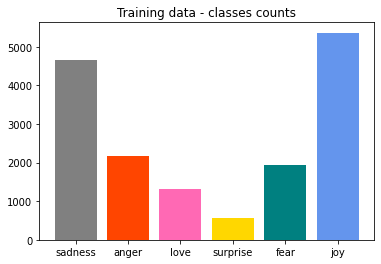

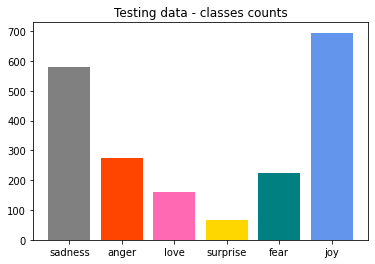

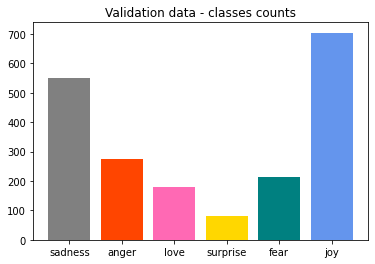

In [6]:
# Visualize classes counts
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

labels = y_train.unique()

def visualization_data(data):
  viz_data = []
  temp_list = data.to_list()
  for label in labels:
    viz_data.append(temp_list.count(label))
  return viz_data

plt.bar(labels, visualization_data(y_train), color = colors)
plt.title("Training data - classes counts")
plt.show()

plt.bar(labels, visualization_data(y_test), color = colors)
plt.title("Testing data - classes counts")
plt.show()

plt.bar(labels, visualization_data(y_val), color = colors)
plt.title("Validation data - classes counts")
plt.show()

In [7]:
print("Data train:\n", y_train.value_counts())
print("\nData test:\n", y_test.value_counts())
print("\nData val:\n", y_val.value_counts())

Data train:
 joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64

Data test:
 joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: Emotion, dtype: int64

Data val:
 joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: Emotion, dtype: int64


In [8]:
# Encode labels
# Sudah disediakan beberapa variable, lengkapi variabel tersebut
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_val = le.fit_transform(y_val)

# y_train = train_test_split(y_train)
# y_test = train_test_split(y_test)
# y_val = train_test_split(y_val)

In [9]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16185


In [10]:
#Read GloVE embeddings
path_to_glove_file = '/content/drive/MyDrive/resource-tugas/Assignment/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 15069 words (1115 misses)


In [168]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)
#code here
model = Sequential([
    Embedding(vocabSize, embedding_dim, input_length=256),
    Bidirectional(LSTM(16, return_sequences=True)),
    LSTM(16),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),        
    Dense(6, activation='softmax')
])

model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 256, 200)          3237000   
                                                                 
 bidirectional_59 (Bidirecti  (None, 256, 32)          27776     
 onal)                                                           
                                                                 
 lstm_80 (LSTM)              (None, 16)                3136      
                                                                 
 dense_119 (Dense)           (None, 64)                1088      
                                                                 
 dropout_75 (Dropout)        (None, 64)                0         
                                                                 
 dense_120 (Dense)           (None, 32)                2080      
                                                     

In [169]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=adam, 
    metrics=['accuracy']
    )

In [157]:
#Callback
callback = EarlyStopping(
    #code here (contains at least : monitor, patience, restore_best_weights)
    monitor='val_loss',
    min_delta=0.01,
    patience=2,
    restore_best_weights=True
)

In [170]:
# Fit model
# code here

history = model.fit(
    X_train,
    y_train,
    epochs=10, 
    steps_per_epoch = 16,
    validation_steps = 8,
    verbose = 1,
    validation_data = (X_test,y_test),
    callbacks = [callback],
    workers=1
    )

Epoch 1/10
16/16 [==============================] - 7s 157ms/step - loss: 1.6543 - accuracy: 0.3081 - val_loss: 1.5427 - val_accuracy: 0.4165
Epoch 2/10
16/16 [==============================] - 1s 87ms/step - loss: 1.3864 - accuracy: 0.4263 - val_loss: 1.1920 - val_accuracy: 0.5415
Epoch 3/10
16/16 [==============================] - 1s 87ms/step - loss: 0.9235 - accuracy: 0.6448 - val_loss: 0.9772 - val_accuracy: 0.6605
Epoch 4/10
16/16 [==============================] - 1s 87ms/step - loss: 0.6679 - accuracy: 0.7533 - val_loss: 0.7719 - val_accuracy: 0.7435
Epoch 5/10
16/16 [==============================] - 1s 90ms/step - loss: 0.5023 - accuracy: 0.8199 - val_loss: 0.7268 - val_accuracy: 0.7685
Epoch 6/10
16/16 [==============================] - 1s 90ms/step - loss: 0.3777 - accuracy: 0.8616 - val_loss: 0.5883 - val_accuracy: 0.8210
Epoch 7/10
16/16 [==============================] - 1s 88ms/step - loss: 0.2548 - accuracy: 0.9191 - val_loss: 0.6261 - val_accuracy: 0.8410
Epoch 8/10
1

In [171]:
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 2s 15ms/step - loss: 0.6354 - accuracy: 0.8010


[0.6354246139526367, 0.8009999990463257]

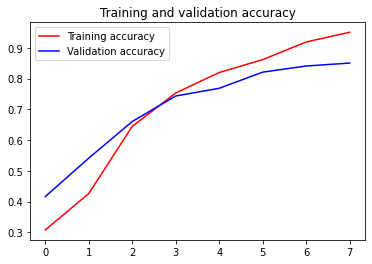

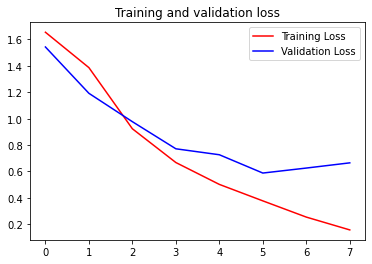

In [172]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [173]:
# Classify custom sample

sentences = [
            #sample teks
             "Yey i got my brithday cake",
             "ponyo is my cat that I love very much",
             "This horror movie really scared me",
             "How could you do that after all the kindness I gave you",
             "I was surprised to get a surprise after I got 1st place in school",
             "I have lost the figure of a very close friend",
             "God is very good has given good people around me",
             "I don’t want to live alone",
             "tonight had something wonderful",
             "You have gone too far to have hurt my child" 
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n")

Yey i got my brithday cake
joy : 0.9998083710670471

ponyo is my cat that I love very much
love : 0.39210307598114014

This horror movie really scared me
fear : 0.5832037329673767

How could you do that after all the kindness I gave you
joy : 0.9991334080696106

I was surprised to get a surprise after I got 1st place in school
fear : 0.5851075649261475

I have lost the figure of a very close friend
sadness : 0.4128371775150299

God is very good has given good people around me
joy : 0.9964297413825989

I don’t want to live alone
sadness : 0.9758507013320923

tonight had something wonderful
joy : 0.9997473359107971

You have gone too far to have hurt my child
sadness : 0.9461237788200378



In [174]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)
    
    
model.save('Emotion Recognition.h5')